# Volumetric Surface Reconstruction

This is an academic project for CS 484 Computational Vision taught by Professor Yuri Boykov.

Submitted by: Millin Gabani - 20499919

Volumetric Surface Reconstruction (VSF) is a subset of multiview stereo reconstruction that recreates a continuous 3D surface using 2D images. For this project, the volumetric graph cuts approach briefly described by Professor Boykov in topic 9 (segmentation) is explored in detail to 3D reconstruction. 

## Overview

1. Acquire a dataset with multiple views of the target structure. The dataset should also include images and projection matrixes for all images.  

2. Create silhouettes for all images using an appropriate segmentation method

3. Create visual hull using silhouettes of all images.

4. Create a volumetric graph of the visual hull with edges weights based on photo-consistency.

5. Perform graph cuts to obtain the final 3D structure



### Dependencies

In [1]:
%matplotlib notebook

from math import sqrt
import numpy as np
import maxflow
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

# Data

For simplicity, existing datasets captured using the Stanford Spherical Gantry were used, the data is provided by Steve Seitz, James Diebel, Daniel Scharstein and Rick Szeliski of Univesity of Washington, Stanford University, Middlebury College and Microsoft Research respectively. 

There are datasets for two structures: 
1. Dinosaur
2. Temple

The following code loads the data and stores it as an instance of Data class.

In [2]:
class Data:
    def __init__(self, data_set):
        self.data_set = data_set
        self.init_bounding_box()
        self.load_camera_info()
        
    def init_bounding_box(self):
        bounding_boxes = {
            'dinoSSR': {
                'x': np.array([-0.07, 0.02]),
                'y': np.array([-0.02, 0.07]),
                'z': np.array([-0.07, 0.02])
            },
            'dinoSR': {
                'x': np.array([-0.07, 0.02]),
                'y': np.array([-0.02, 0.07]),
                'z': np.array([-0.07, 0.02])
            },
            'dinoR': {
                'x': np.array([-0.03, 0.06]),
                'y': np.array([-0.022, 0.11]),
                'z': np.array([-0.02, 0.06])
            },
            'templeSR': {
                'x': np.array([-0.08, 0.03]),
                'y': np.array([0.0, 0.18]),
                'z': np.array([-0.02, 0.06])
            }
        }
        self.bounding_box = bounding_boxes[self.data_set]
        
    def load_camera_info(self):
        
        # Dictionary of data_sets with image_paths
        image_paths = {
            'dinoSSR': 'dinoSuperSparseRing/',
            'dinoSR': 'dinoSparseRing/',
            'dinoR': 'dinoRing/',
            'templeSR': 'templeSparseRing/'
        }
        
        # Open file in read mode
        path = image_paths[self.data_set]
        fp = open(path+self.data_set+'_par.txt', 'r')  

        num_images = int(fp.readline())
        self.size = num_images
        
        P = []           # projection matrices
        T = []           # camera positions
        imgs = []        # images
        
        for i in xrange(num_images):
            raw_info = fp.readline().split()
            img_name = raw_info[0]
            raw_info = map(float, raw_info[1:])

            # Projection Matrix of the camera
            K = np.array(raw_info[0:9]).reshape(3,3)
            R = np.array(raw_info[9:18]).reshape(3,3)
            t = np.array(raw_info[18:])
            Rt = np.stack((R[:,0], R[:,1], R[:,2], t), axis=1)
            P.append(np.matmul(K, Rt))
            
            # Position of camera is Translation vector
            T.append(t)

            # Read Image and store
            img = plt.imread(path+img_name)
            imgs.append(img)
        
        self.P = np.array(P)
        self.T = np.array(T)
        self.imgs = np.array(imgs)
        
    def display_dataset(self, silhouettes=False):
        plt.figure()
        r = self.size/4
        
        for i in xrange(self.size):
            plt.subplot(r,4,i+1)
            if silhouettes:
                plt.imshow(self.sils[i])
            else:
                plt.imshow(self.imgs[i])
            plt.show()
    
    def sample_image(self):
        return self.imgs[np.random.randint(self.size)]
            
    def init_silhouttes(self, Segment):
        sils = []        # silhouettes
        
        for img in self.imgs:
            # create silhouttes using segmentation method
            sil = Segment(img).run()
            sils.append(sil)
        
        self.sils = np.array(sils)
    

## Dinosaur

The dinosaur dataset has 16 images taken from different viewing angle using Stanford Spherical Gantry.

Image shape:  (480, 640, 3)


<IPython.core.display.Javascript object>


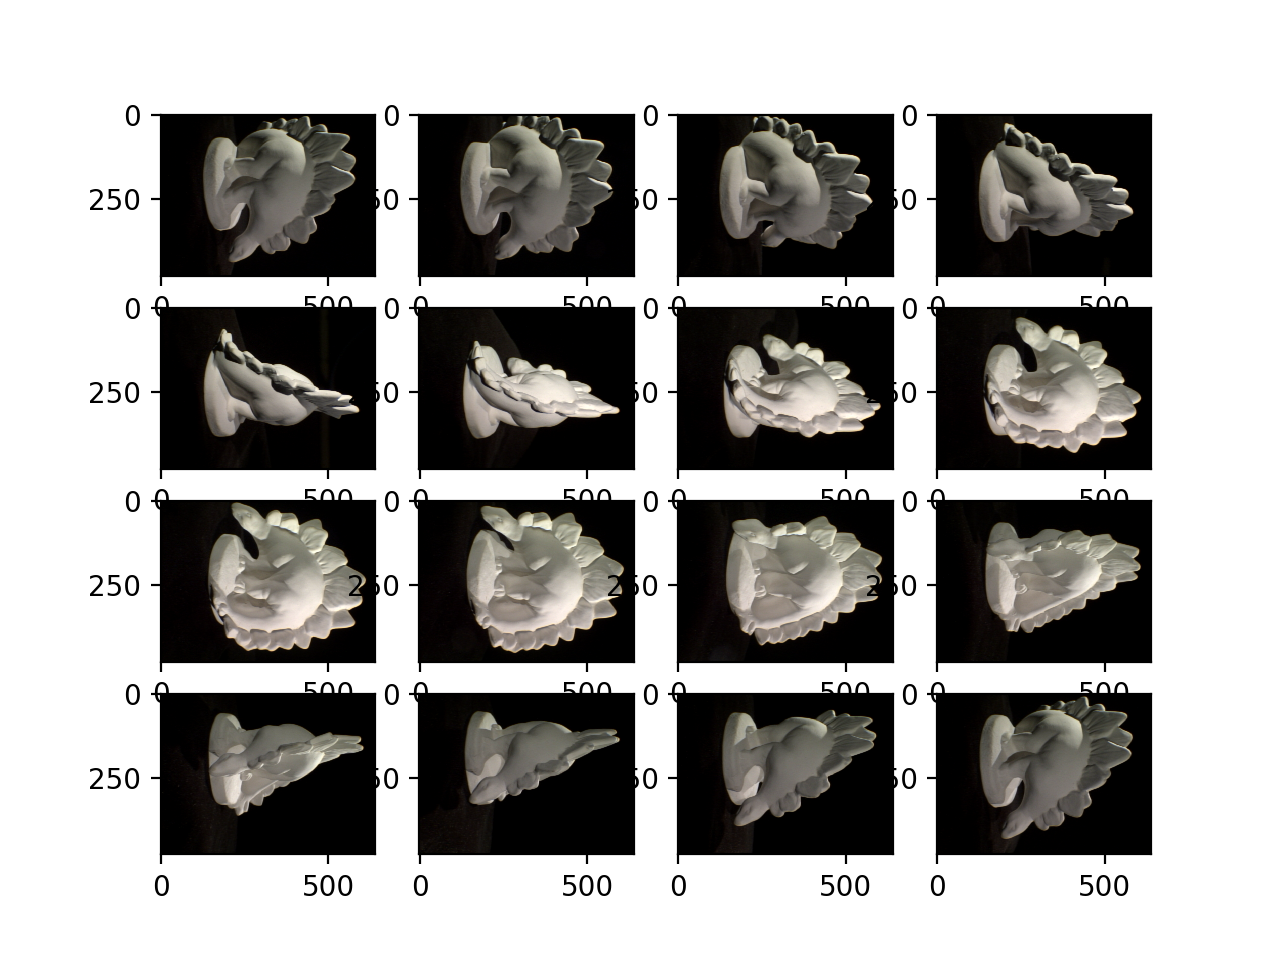

In [3]:
dino = Data('dinoSR')

print "Image shape: ", dino.imgs[0].shape

dino.display_dataset()

## Temple

The temple dataset also has 16 images taken from different viewing angle using Stanford Spherical Gantry.

Image shape:  (480, 640, 3)


<IPython.core.display.Javascript object>


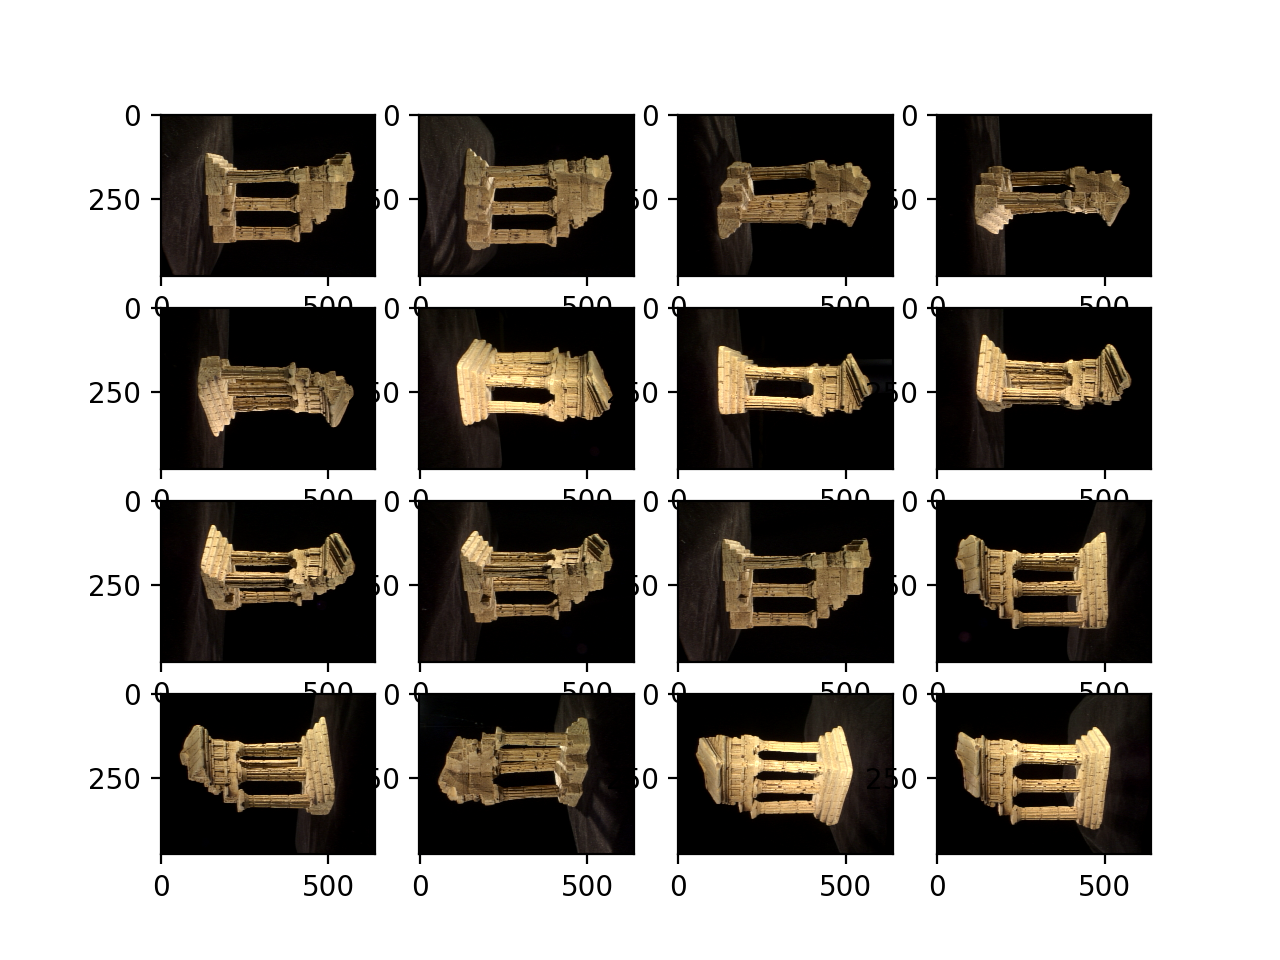

In [4]:
temple = Data('templeSR')

print "Image shape: ", temple.imgs[0].shape

temple.display_dataset()

# Segmentation

The following plots show histogram distribution of temple and dinosaur dataset

In [5]:
def plot_intensity_histogram(img):
    plt.figure()
    for i in xrange(img.shape[2]):
        plt.subplot(1,3,i+1)
        plt.hist(img[:,:,i].flatten())
        plt.show()

#### Dinosaur image histogram 

<IPython.core.display.Javascript object>


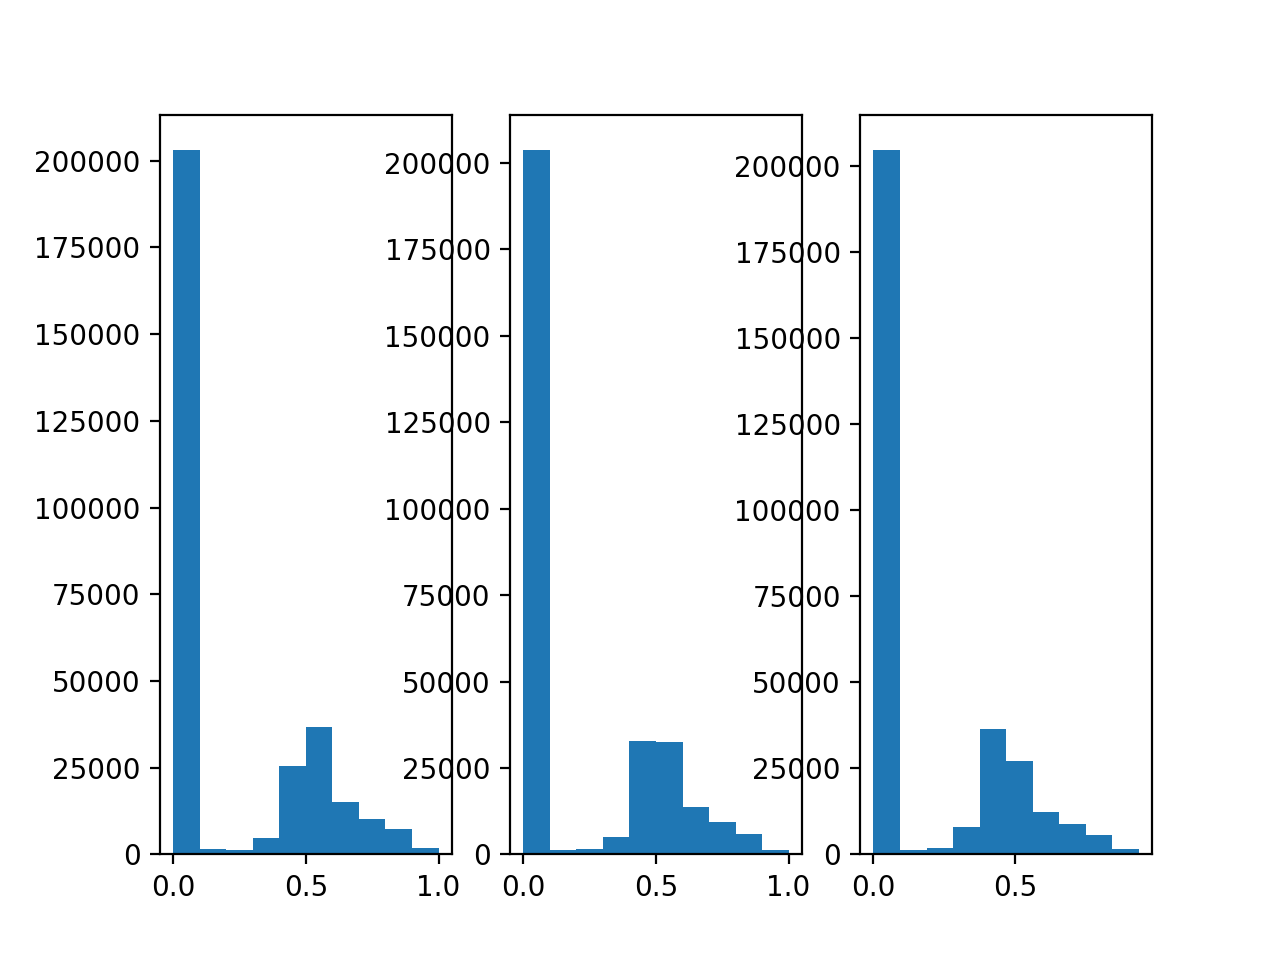

In [6]:
plot_intensity_histogram(dino.sample_image())

### Temple Image Histogram

<IPython.core.display.Javascript object>


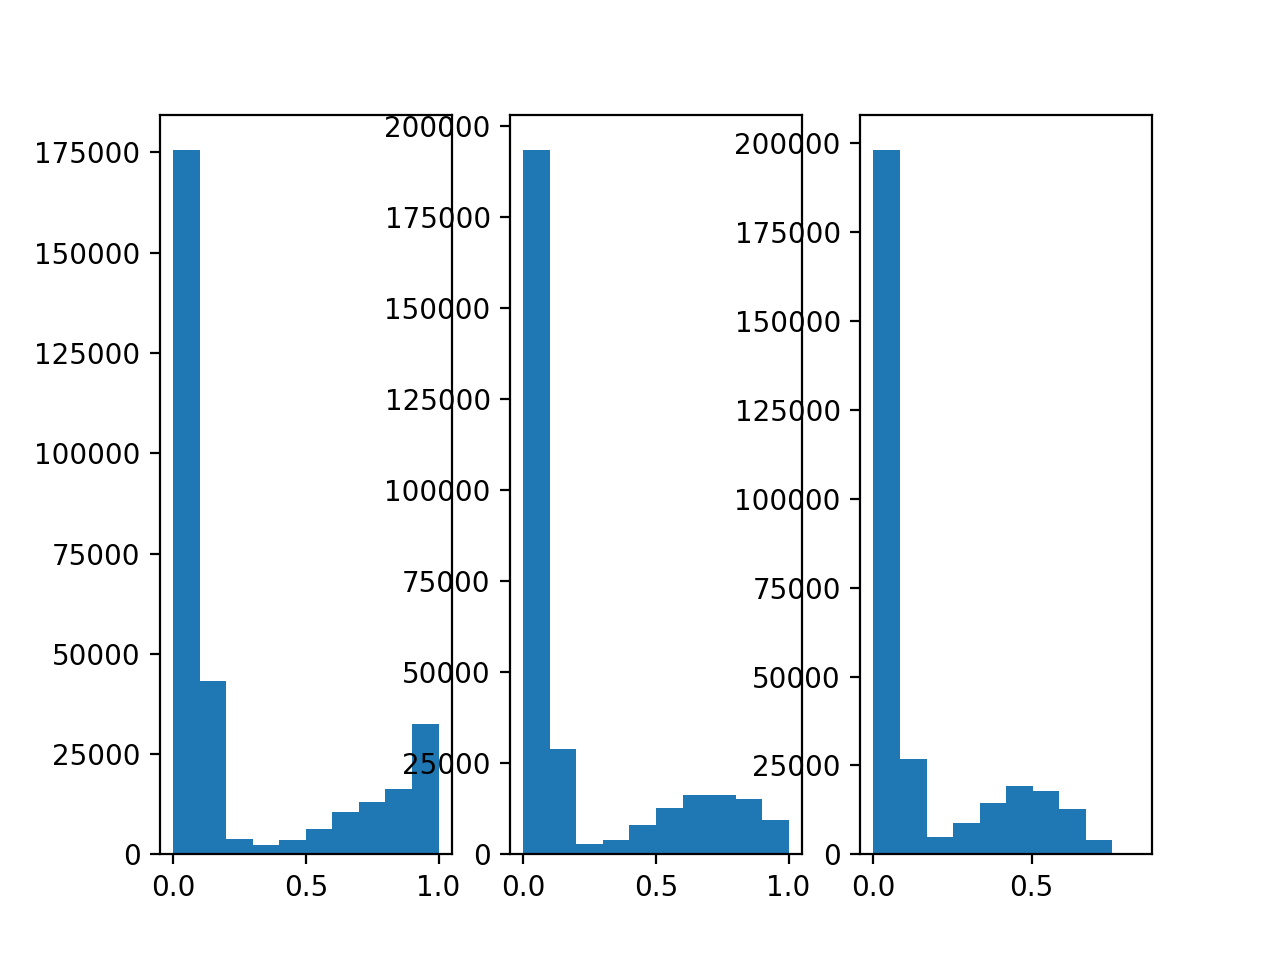

In [7]:
plot_intensity_histogram(temple.sample_image())

Since the background has low intensity and target object has high intensity,  a simple threshold segmentation can do quite a good job for creating silhouettes.

## Threshold Segmentation

From the given histogram and trial and error, a threshold value of 0.04 was selected for both dataset. As threshold value increased the segmentation got better but some pixels from target structure were classifies as background. To avoid such gaps, a lower threshold vaue was picked.

The background pixels that are included in the target object will make visual hull slightly bulkier. However, that part will be removed during volumetric graph cuts of visual hull.

In [8]:
class ThresholdSegment:
    def __init__(self, image, threshold=0.05):
        self.image = image
        self.threshold = threshold
    
    def run(self):
        sil = np.zeros((self.image.shape[0], self.image.shape[1]))
        sil[np.where(self.image > self.threshold)[:2]] = 1
        return sil


### Dinosaur Silhouettes

<IPython.core.display.Javascript object>


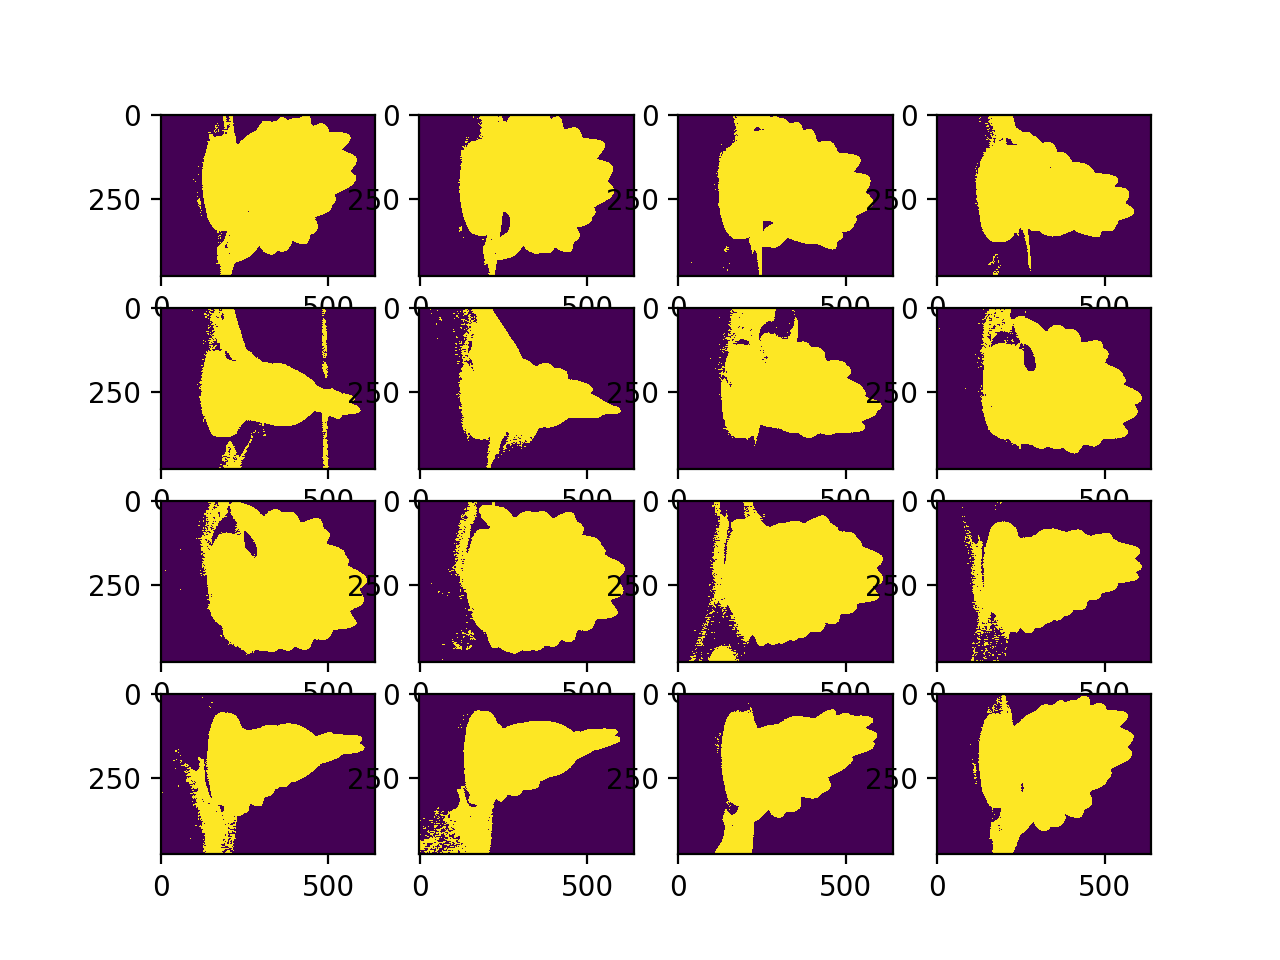

In [9]:
dino.init_silhouttes(ThresholdSegment)
dino.display_dataset(silhouettes=True)

### Temple Silhouettes

<IPython.core.display.Javascript object>


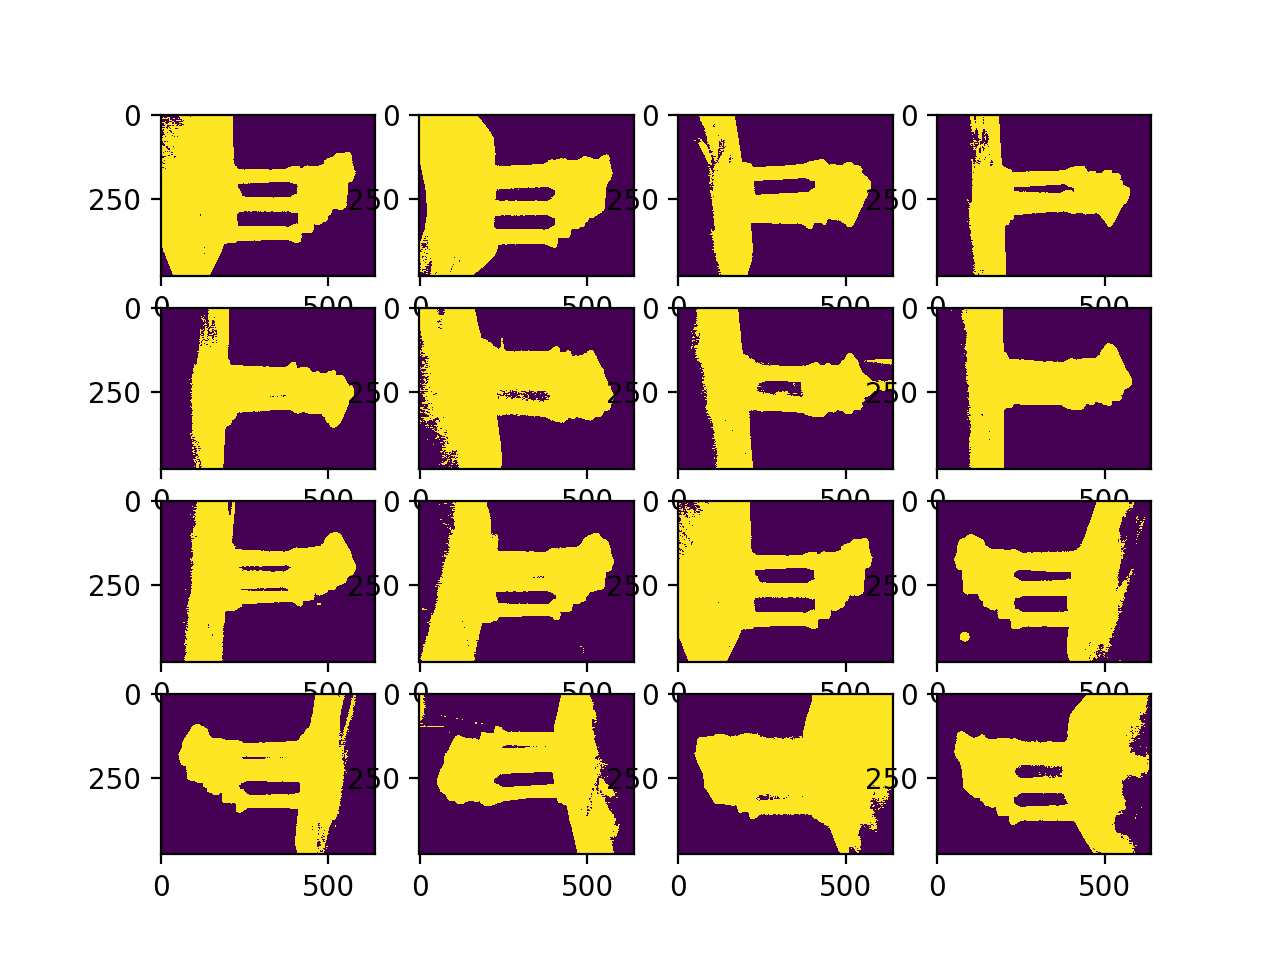

In [10]:
temple.init_silhouttes(ThresholdSegment)
temple.display_dataset(silhouettes=True)

 ## Other Segmentation Methods
 
 Alternatively, we could also perform k-means superpixels or semi-supervised like interactive graph-cuts for datasets that cannot be segmented using threshold segmenting. This was out of scope for a single person project and is thus not done here.

# Visual Hull

A visual hull is a geometric entity created by shape-from-silhouette 3D reconstruction technique. The technique used here is intersection of cones.

The following steps describe an overview of the process:
1. Project each camera's silhouette into space to obtain a 3D cone
2. The intersection of the cones generated by each image gives the visual hull of the object.

In other words, visual hull is the smallest 3D shape consistent with all silhouettes.

The algorithm for creating visual hull used is described below:
1. Create a bounding cuboid structure and initialize it with voxels of some size.
2. Initialize all the voxels with a value 1.
3. For each camera position:<br>
    3.1 Project all voxels in cuboid to the image using Projection matrix -> $P_i = K_i[R_i | T_i]$ <br>
    3.2 Change values of all voxels from 1 to 0 that are not projected on the camera silhouette $S_i$
4. Create a grid the update voxel_list
5. Plot the voxel grid

In [11]:
class Voxel:
    def __init__(self, args):
        self.x = args[0]
        self.y = args[1]
        self.z = args[2]
        self.val = args[3]
    
    # Prints details about the voxel
    def log(self):
        print "\tx: ", self.x
        print "\ty: ", self.y
        print "\tz: ", self.z
        print "\tval: ", self.val
    
    # Returns homogeneous coordinates of the voxel
    def homo(self):
        return np.array([self.x, self.y, self.z, 1]).reshape(4, 1)

class VisualHull:
    def __init__(self, 
                 data, 
                 voxel_size=np.array([0.002, 0.002, 0.002])):
        
        self.data = data
        self.voxel_size = voxel_size

        self.sils = self.data.sils
        self.P = self.data.P
        
        self.img_height = self.data.imgs.shape[1]
        self.img_width = self.data.imgs.shape[2]
        
    def initialize_voxels(self, xlim, ylim, zlim):
        
        # Determine shape of visual hull grid
        hull_shape = np.zeros(3)
        hull_shape[0] = abs(xlim[1] - xlim[0])/self.voxel_size[0]
        hull_shape[1] = abs(ylim[1] - ylim[0])/self.voxel_size[1]
        hull_shape[2] = abs(zlim[1] - zlim[0])/self.voxel_size[2]
        self.hull_shape = hull_shape + np.ones(3)
        
        # Compute total voxels using grid shape
        self.total_voxels = np.prod(self.hull_shape)

        # List storing (x, y, z, val) of each voxel
        self.voxels2D_list = np.ones((int(self.total_voxels), 4), float)
        
        # Compute increment and decrement step direction
        sx = xlim[0]
        ex = xlim[1]
        sy = ylim[0]
        ey = ylim[1]
        sz = zlim[0]
        ez = zlim[1]

        if ex > sx:
            x_step = self.voxel_size[0]
        else:
            x_step = -self.voxel_size[0]

        if ey > sy:
            y_step = self.voxel_size[1]
        else:
            y_step = -self.voxel_size[1]

        if ez > sz:
            z_step = self.voxel_size[2]
        else:
            z_step = -self.voxel_size[2]
            
        self.x_step = x_step
        self.y_step = y_step
        self.z_step = z_step
        
        x_linspace = np.linspace(sx, ex, int(self.hull_shape[0]))
        y_linspace = np.linspace(sy, ey, int(self.hull_shape[1]))
        z_linspace = np.linspace(sz, ez, int(self.hull_shape[2]))
        
        # Initialize voxel list
        l = 0;
        for z in z_linspace:
            for x in x_linspace:
                for y in y_linspace:
                    self.voxels2D_list[l, 0:3] = np.array([x, y, z])
                    l = l+1
                    
    def create_visual_hull(self):
        
        # Homogeneous 3D world coordinates 
        object_points3D_homo = np.transpose(self.voxels2D_list)
        
        # Iterate through each camera position 
        print "Processing frames: ",
        for i in xrange(self.P.shape[0]):
            print i+1, " ",
            
            # Homogeneous image coordinate for camera/image i
            points2D_homo = np.matmul(self.P[i], object_points3D_homo)
            
            # Remove infinity points
            inf_ind = np.where(points2D_homo[2] == 0)
            points2D_homo[:, inf_ind] = 1
            
            # Image coordinates
            points2D = np.divide(points2D_homo[0:2], [points2D_homo[2], points2D_homo[2]]);

            # Remove points outside image boundary
            ind_x_lt_0 = np.where(points2D[0] < 0)
            ind_y_lt_0 = np.where(points2D[1] < 0)
            ind_x_gt_w = np.where(points2D[0] >= self.img_width)
            ind_y_gt_h = np.where(points2D[1] >= self.img_height)
            points2D[:, ind_x_lt_0] = 1
            points2D[:, ind_y_lt_0] = 1
            points2D[:, ind_x_gt_w] = 1
            points2D[:, ind_y_gt_h] = 1
            
            # Make voxel value 0 for those not being projected
            ind = np.ravel_multi_index(
                (points2D[1,:].astype(int), points2D[0,:].astype(int)), 
                dims=(self.img_height, self.img_width), order='C')
            cur_sil = self.data.sils[i]
            img_val = cur_sil.ravel()[ind]
            zero_ind = np.where(img_val == 0)[0]
            
            # Update list of voxels
            self.voxels2D_list[zero_ind, 3] = 0
            
    def create_grids(self):
        # Initialize Grids - one with all voxel info, one just with voxel values
        self.voxel3D = np.zeros([int(self.hull_shape[1]), int(self.hull_shape[0]), int(self.hull_shape[2])], dtype=float)
        self.visual_hull = np.zeros([int(self.hull_shape[1]), int(self.hull_shape[0]), int(self.hull_shape[2])], dtype=object)

        # Assign values in 3D grid
        l=0
        for zi in xrange(self.voxel3D.shape[2]):
            for xi in xrange(self.voxel3D.shape[1]):
                for yi in xrange(self.voxel3D.shape[0]):
                    self.voxel3D[yi, xi, zi] = self.voxels2D_list[l, 3]
                    self.visual_hull[yi, xi, zi] = Voxel(self.voxels2D_list[l,:])
                    l = l+1
                    
    def plot_marching_cube(self):
        # Display resulting triangular mesh using Matplotlib.
        verts, faces, normals, values = measure.marching_cubes_lewiner(self.voxel3D.T, 0)

        fig = plt.figure()
        ax = fig.gca(projection='3d')

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces])
        mesh.set_edgecolor('k')
        ax.add_collection3d(mesh)

        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        ax.set_zlabel("z-axis")

        ax.set_xlim(0, self.voxel3D.T.shape[0]) # a = 6 (times two for 2nd ellipsoid)
        ax.set_ylim(0, self.voxel3D.T.shape[1]) # b = 10
        ax.set_zlim(0, self.voxel3D.T.shape[2]) # c = 16

        plt.tight_layout()
        plt.show()

    def run(self):
        print "Initializing Voxels ->", 
        self.initialize_voxels(
            self.data.bounding_box['x'], 
            self.data.bounding_box['y'], 
            self.data.bounding_box['z'])
        print "Forming Visual Hull ->",
        self.create_visual_hull()
        print "-> Creating 3D grids ->",
        self.create_grids()
        print "Plotting marching cubes ... ",
        self.plot_marching_cube()


## Voxel Sizes

Visual Hulls for two different voxel sizes for each dataset were created for comparision, the smaller the voxel dimensions the higher is the resolution of visual hull. 

Due to limitations in computing power, the resolution of the 3D structure was kept low.

Note: The 3D plots don't have shadows so they might not show enough detail in images, I would recommend to run the notebook and rotate the structures to see better results.

In [12]:
big_voxels = [0.003, 0.003, 0.003]
med_voxels = [0.002, 0.002, 0.002]
small_voxels = [0.001, 0.001, 0.001]

## Dino Visual Hull

Appendix A provides multiple rotation of the Dino Visual Hull

### Low resolution (med voxels)

Initializing Voxels -> Forming Visual Hull -> Processing frames:  1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   -> Creating 3D grids -> Plotting marching cubes ... 

<IPython.core.display.Javascript object>


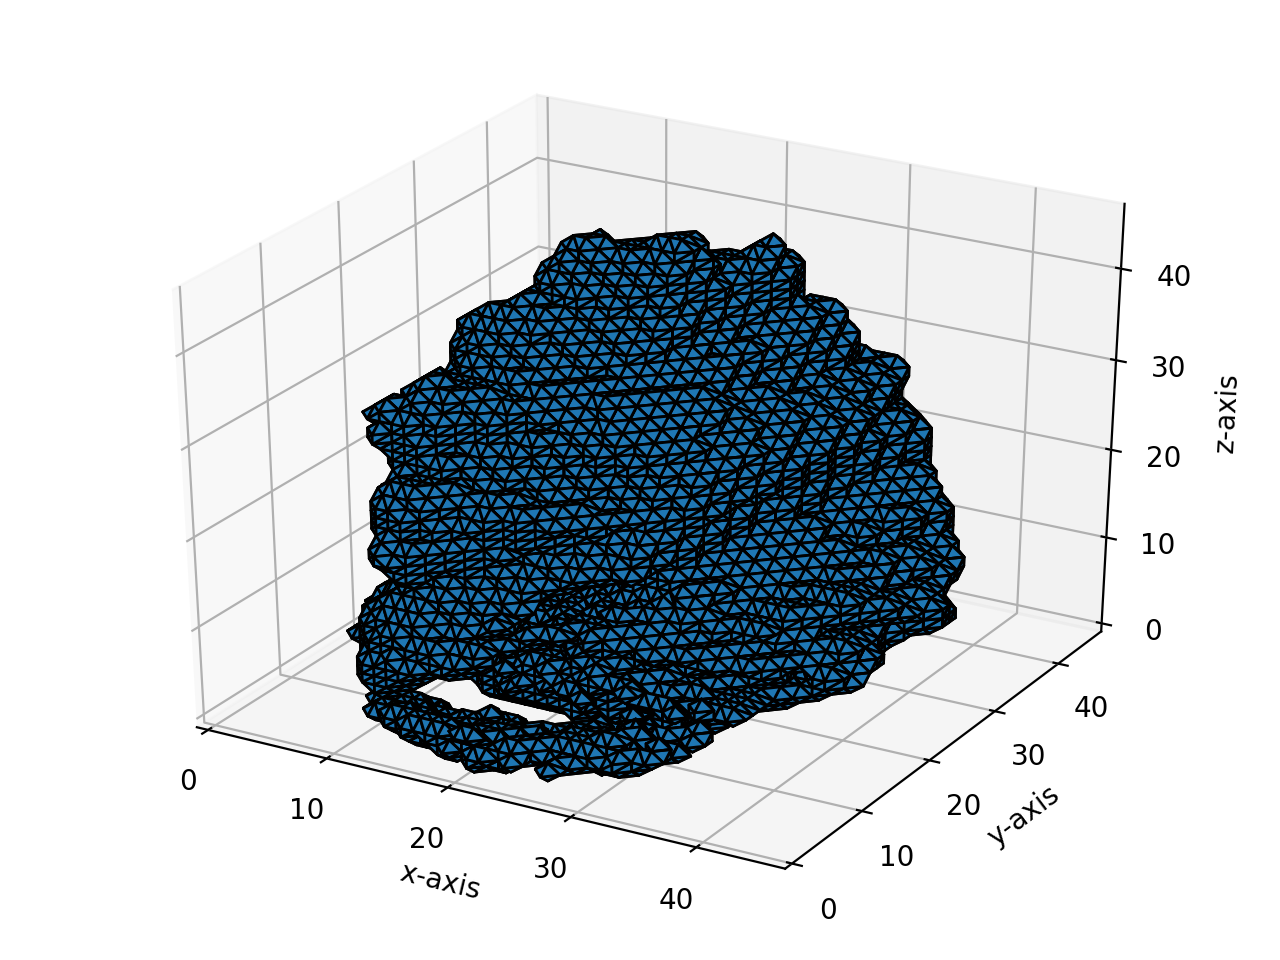

In [13]:
dino_hull_lr = VisualHull(dino, np.array(med_voxels))
dino_hull_lr.run()

### High resolution (small voxels)

Initializing Voxels -> Forming Visual Hull -> Processing frames:  1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   -> Creating 3D grids -> Plotting marching cubes ... 

<IPython.core.display.Javascript object>


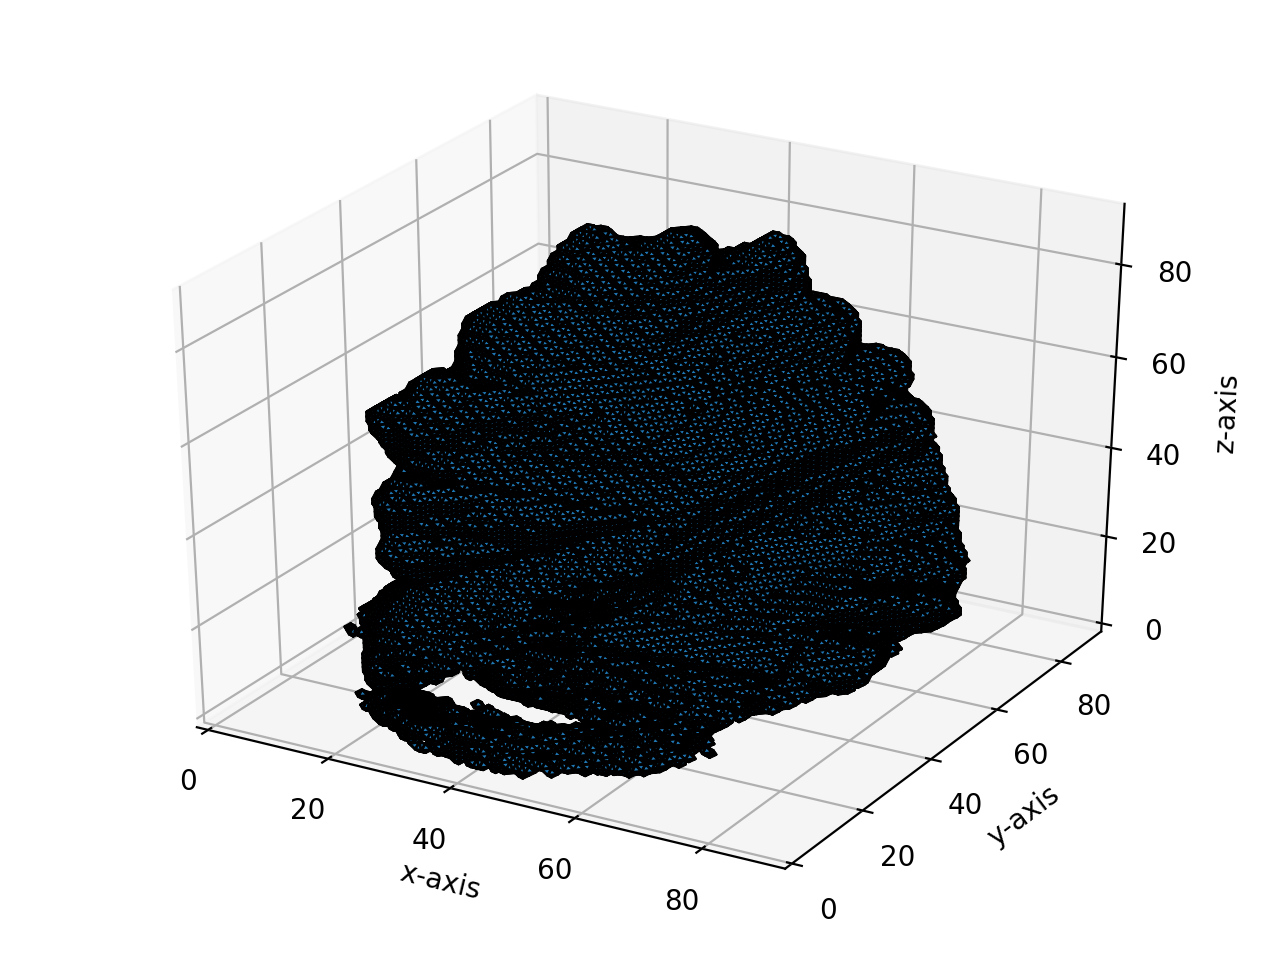

In [14]:
dino_hull_hr = VisualHull(dino, np.array(small_voxels))
dino_hull_hr.run()

## Temple Visual Hull

Appendix B provides multiple rotation of the Temple Visual Hull

### Low Resolution (big voxels)

Initializing Voxels -> Forming Visual Hull -> Processing frames:  1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   -> Creating 3D grids -> Plotting marching cubes ... 

<IPython.core.display.Javascript object>


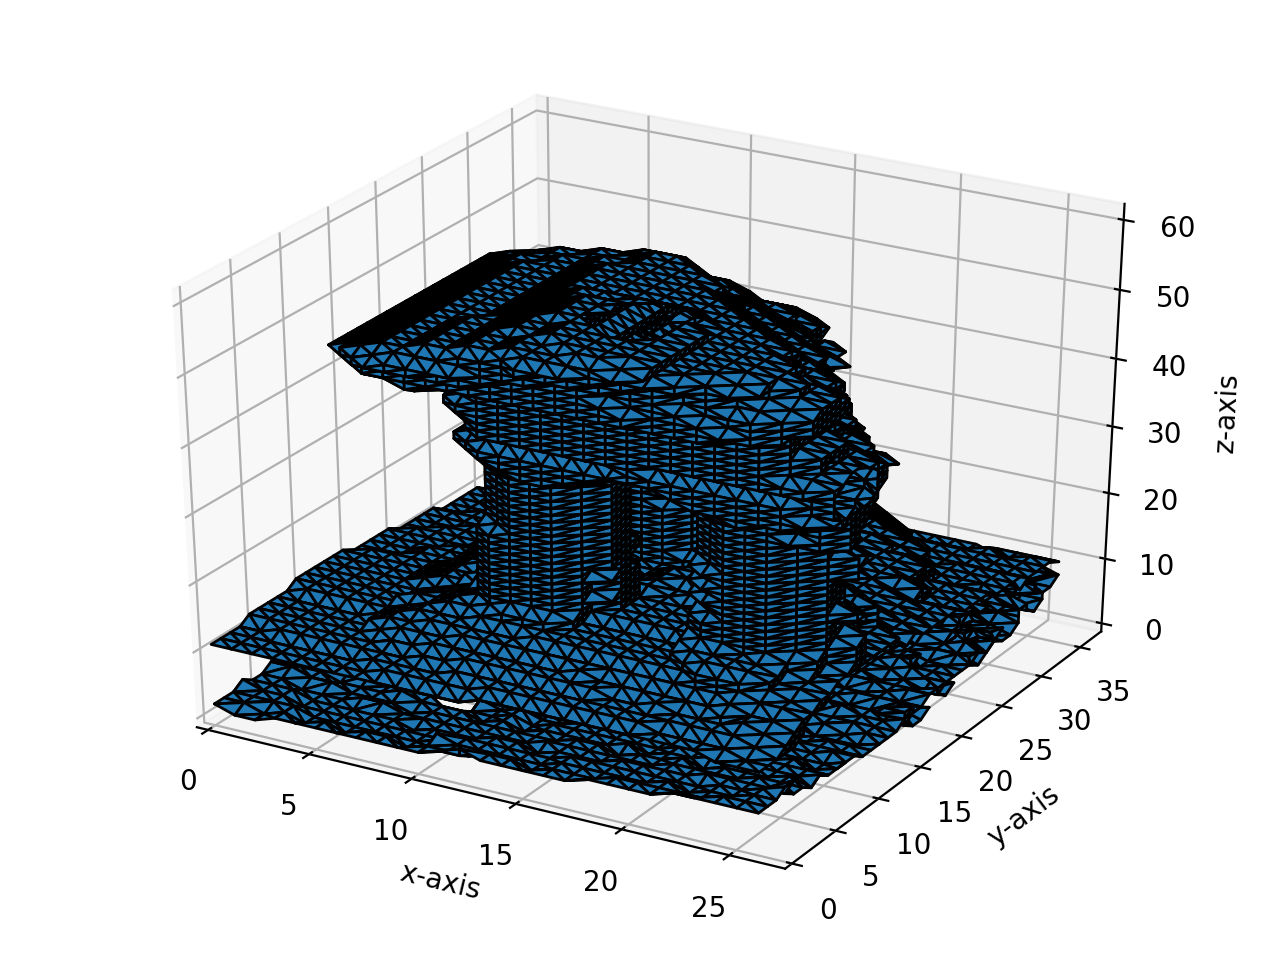

In [15]:
temple_hull_lr = VisualHull(temple, np.array(big_voxels))
temple_hull_lr.run()

### High Resolution (med voxels)

Initializing Voxels -> Forming Visual Hull -> Processing frames:  1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   -> Creating 3D grids -> Plotting marching cubes ... 

<IPython.core.display.Javascript object>


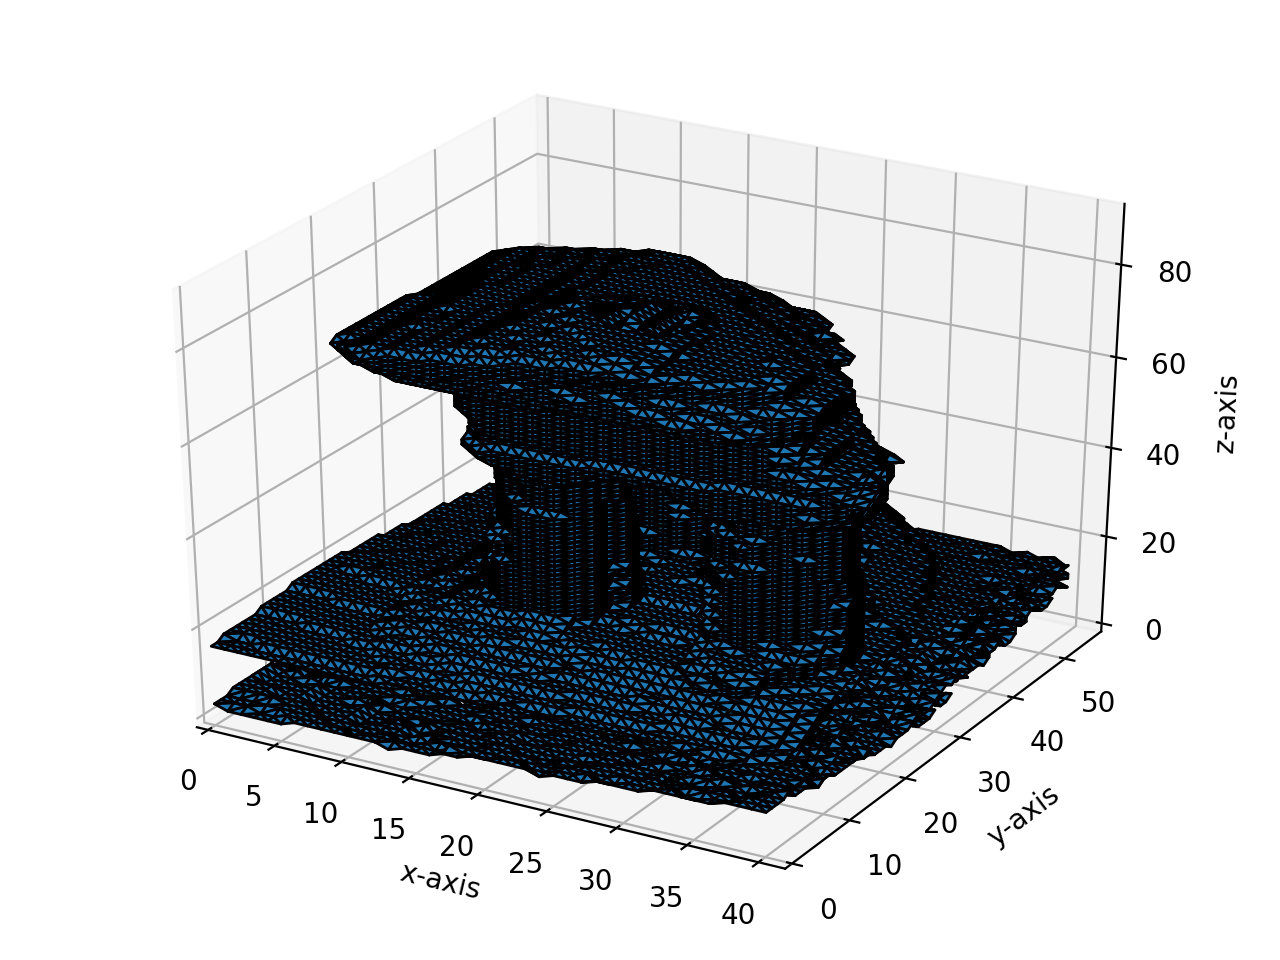

In [16]:
temple_hull_hr = VisualHull(temple, np.array(med_voxels))
temple_hull_hr.run()

# Volumetric Graph Cuts

The 3D structure can be further refined using volumetric graph-cuts via photo-consistency.

## Photo Consistency Metric

Photo-consistency, $\rho$, of a scene point, $x$, can be evaluated by comparing its projections in the images where it is visible. Variance of pixel intensities was used as a comparison parameter in this project.

$$ \rho(x) = \Sigma \; {|I_i - I_{avg}|}^2 $$

where,<br>
$x$ is scene point location in 3D<br>
$I$ is intensity of pixel $i$ (RGB values)<br>
$I_{avg}$ is the average intensity

For the purpose of the project, only the projections of a scene point on its closest k cameras were considered visible. This is not always true, but the complexity of code increases significantly if we want to find all visible projections of scene point. So, to avoid complications, it was not pursued

## Graph Structure

This graph structure was partially borrowed from "Multiview Stereo via Volumetric Graph-Cuts and Occlusion Robust Photo-Consistency" paper written by George Vogiatzis, Carlos Hernandez, Philip Torr, and Roberto Cipolla.

### Node
The node of the graphs represents active voxels in the visual hull. Each node is connected to 6 neighbouring nodes (neighbouring voxels location based) through an n-link. The six neighbours are left, right, top, bottom, front and back.

### N-Links (Edges)
The weight, $W_n$, of an n-link edge is a function of photo-consistency of the edge. The scene point position of the edge used for photo-consistency metric is the midpoint of two voxel location the edge is connecting.

$$ W_n(e) = \frac{4 \pi h^2}{3}\rho\left(\frac{x_i + x_j}{2}\right) $$

where, <br>
$h$ is size of voxel<br>
$x_i$ is location of first voxel connected to the edge $e$<br>
$x_j$ is location of second voxel connected to the edge $e$<br>

Note: We can improve the weight function for n-links using robust techniques such as saturation of weights above a certain value. This emulates a truncated quadratic function since $\rho$ is quadratic.

### T-links (Sink)
All the voxels exposed to the surface of visual hull were connected to sink with an $\infty$ weight.

### T-links (Source)
All the non-surface voxels in visual hull are connected to the source using weight $W_b$

$$ W_b = \lambda h^3 $$

where, <br>
$h$ is size of voxel<br>
$\lambda$ is a hyper parameter to tune graph-cuts

### Optimization

Graph cuts are done using maxflow/minimum-cut algorithm. PyMaxFlow was used to create a graph and perform graph-cuts using maxflow algorithm. 

In [17]:
class VolumetricGraphCuts:
    
    def __init__(self, data, visual_hull, k=4, _lambda=10e6):
        
        # Initialize Visual Hull
        self.hull = visual_hull.visual_hull
        self.init_hull_surf()
        self.voxel_size = visual_hull.voxel_size
        self.voxel_list = visual_hull.voxels2D_list
        
        # Initialize Camera/Image data
        self.data = data
        self.T = self.data.T
        self.P = self.data.P
        self.imgs = self.data.imgs
        
        self.img_height = self.data.imgs.shape[1]
        self.img_width = self.data.imgs.shape[2]
        
        
        # Initialize Hyper parameters
        self.k = k
        self._lambda = _lambda
        
        print "Initializing Graph ..."
        self.init_graph(debug=True)
        print "done"
        
    def init_hull_surf(self):
        # Visual hull with only surface values
        self.hull_surf = np.zeros(self.hull.shape, float)
        for y in xrange(self.hull.shape[0]):
            for x in xrange(self.hull.shape[1]):
                for z in xrange(self.hull.shape[2]):
                    if self.hull[y,x,z].val == 1:
                        self.hull_surf[y,x,z] = 1
                        if x > 0 and x < self.hull.shape[1]-1 and (self.hull[y, x-1, z].val == 0 or self.hull[y, x+1, z].val == 0):
                            self.hull_surf[y,x,z] = 2
                        if y > 0 and y < self.hull.shape[0]-1 and (self.hull[y-1, x, z].val == 0 or self.hull[y+1, x, z].val == 0):
                            self.hull_surf[y,x,z] = 2
                        if z > 0 and z < self.hull.shape[2]-1 and (self.hull[y, x, z-1].val == 0 or self.hull[y, x, z+1].val == 0):
                            self.hull_surf[y,x,z] = 2

    def init_graph(self, debug=False):
        # Initialize Graph
        if debug:
            print "\tGraph ->",
        self.graph = maxflow.GraphFloat()
        if debug:
            print "created"
        
        if debug:
            print "\tNodes ->",
        self.node_ids = self.graph.add_grid_nodes(self.hull_surf.shape)
        if debug:
            print "added"
        
        if debug:
            print "\tT-links ->",
        self.add_sink_edges() 
        if debug:
            print "sink done ->",
        self.add_source_edges()
        if debug:
            print "source done"
            
        if debug:
            print "\tN-links ->",
        self.add_n_links()
        if debug:
            print "done"
        
    def add_sink_edges(self):
#         def _ind(x, y, z):
#             return z*self.hull.shape[2] + x*self.hull.shape[1] + y*self.hull.shape[0]
        
#         for z in xrange(self.hull.shape[2]):
#             for x in xrange(self.hull.shape[1]):
#                 for y in xrange(self.hull.shape[0]):
#                     if self.hull[y,x,z].val == 0 or self.hull[y,x,z].val == 2:
#                         self.graph.add_tedge(_ind(x,y,z), 0, float('inf'))
        
        surf_inds = self.node_ids[np.where(self.hull_surf == 2)]

        # Add t-link with inf weight to surface nodes 
        for ind in surf_inds:
            self.graph.add_tedge(ind, 0, float('inf'))
    
    def add_source_edges(self):
        non_surf_inds = self.node_ids[np.where(self.hull_surf == 1)]
    
        # Add t-link of weight lambda * h^3 to all nodes that are not on surface
        self.Wb = self._lambda * np.prod(self.voxel_size)
#         self.Wb = 5
        for ind in non_surf_inds:
            self.graph.add_tedge(ind, self.Wb, 0)
            
    def photo_consistency(self, world_coord):
        d = []
        for t in self.T:
            d.append(np.linalg.norm(world_coord[:3]+t))
        inds = np.argsort(d)[:self.k]
        
        intensities = []
        for i in inds:
            img_coord = np.matmul(self.P[i], world_coord)
            
            # Skip if infinity point
            if img_coord[2] == 0:
                continue

            # Image coordinates
            img_coord = np.divide(img_coord[0:2], [img_coord[2], img_coord[2]]);

            # Skip points outside image boundary
            if (img_coord[0] < 0 or img_coord[0] >= self.img_width):
                continue
            if (img_coord[1] < 0 or img_coord[1] >= self.img_height):
                continue
            
            intensities.append(self.imgs[i, int(img_coord[1]), int(img_coord[0])])
                
        intensities = np.array(intensities)
        avg_I = np.mean(intensities, axis=0)
        
        pc = 0
        for I in intensities:
            pc += sqrt((I[0] - avg_I[0])**2 + (I[1] - avg_I[1])**2 + (I[2] - avg_I[2])**2)**2
        
        return pc
            
            
    def add_n_links(self, debug=False):
        def midpoint(p1, p2):
            return (p1 + p2)/2.0
        
        def valid_neighbour(ind):
            return ind[0] >= 0 and ind[1] >= 0 and ind[2] >= 0 and self.hull[ind].val == 1 
        
        inds = np.where(self.hull_surf > 0)
        self.weights = np.zeros((inds[0].shape[0], 6), float)
        nu = (4*np.pi*(self.voxel_size[0]**2))/3.0

        for j in xrange(inds[0].shape[0]):
            x = inds[1][j]
            y = inds[0][j]
            z = inds[2][j]
            self.weights[j, :3] = self.hull[y,x,z].homo()[:3, 0]
            vox_ind = self.node_ids[y,x,z]
            vox = self.hull[y,x,z]
            
            neighbours = [(y, x-1, z), (y-1, x, z), (y, x, z-1)]
            
            for i,neighbour in enumerate(neighbours):
                if valid_neighbour(neighbour):
                    neigh_ind = self.node_ids[neighbour]
                    neigh_vox = self.hull[neighbour]
                    edge_coord = midpoint(vox.homo(), neigh_vox.homo())
                    W = nu * self.photo_consistency(edge_coord)
                    self.graph.add_edge(vox_ind, neigh_ind, W, W)
                    self.weights[j, i+3] = W
    
    def create3D_structure(self):        
        count_rm=0
        count_st=0
        self.structure3D = np.zeros(self.hull.shape, float)
        for z in xrange(self.hull.shape[2]):
            for x in xrange(self.hull.shape[1]):
                for y in xrange(self.hull.shape[0]):
                    if self.hull[y,x,z].val == 0:
                        self.structure3D[y,x,z] = 0
                    else:
                        node_id = self.node_ids[y,x,z]
#                         self.structure3D[y,x,z] = self.graph.get_segment(node_id)
                        if self.graph.get_segment(node_id) == 0:
                            self.structure3D[y,x,z] = 1
                            count_st += 1
                        else:
                            self.structure3D[y,x,z] = 0
                            count_rm += 1
        print "\tVoxels in visual hull: ", count_st+count_rm
        print "\tNumber of voxels removed during graph-cuts: ", count_rm
        print "\tVoxels in final result: ", count_st
    
    def plot3D_structure(self):
        # Display resulting triangular mesh using Matplotlib.
        verts, faces, normals, values = measure.marching_cubes_lewiner(self.structure3D.T, 0)

        fig = plt.figure()
        ax = fig.gca(projection='3d')

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces])
        mesh.set_edgecolor('k')
        mesh.set_facecolor('c')
        ax.add_collection3d(mesh)

        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        ax.set_zlabel("z-axis")

        ax.set_xlim(0, self.structure3D.T.shape[0]) # a = 6 (times two for 2nd ellipsoid)
        ax.set_ylim(0, self.structure3D.T.shape[1]) # b = 10
        ax.set_zlim(0, self.structure3D.T.shape[2]) # c = 16

        plt.tight_layout()
        plt.show()
        
    def plot_voxels(self):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.voxels(self.structure3D, facecolors='red', edgecolor='k')

        plt.show()
    
    def run(self):
        print "Running MaxFlow ->",
        self.graph.maxflow()
        print "done"
        
        print "Create 3D Structure from graph ..."
        self.create3D_structure()
        print "done"
        
        print "Plot final result ->",
        self.plot3D_structure()
        print "done"

# Results

As shown, we have a very good 3D representation of the target structure. 

Each 3D plot shows the number of voxels that were removed from the visual hull when graph-cuts was performed. This showed that the graph-cuts performed as intended, as the result is an improved the 3D representation of visual hull. 

### Dino Results 

The the graph cuts was performed on low resolution dino visual hull. Note that the neck of dinosaur is quite visible now that graph cuts has been performed. In visual hull, the neck wasn't defined this well.

It can be seen from the logs that total of $4298$ voxels were removed from visual hull when graphs cut was performed. Visual hull initially had $16323$ voxels, and resulting structure had $12025$ voxels.

In [18]:
dino_cut = VolumetricGraphCuts(dino, dino_hull_lr)

Initializing Graph ...
	Graph -> created
	Nodes -> added
	T-links -> sink done -> source done
	N-links -> done
done


Running MaxFlow -> done
Create 3D Structure from graph ...
	Voxels in visual hull:  16323
	Number of voxels removed during graph-cuts:  4298
	Voxels in final result:  12025
done
Plot final result ->

<IPython.core.display.Javascript object>


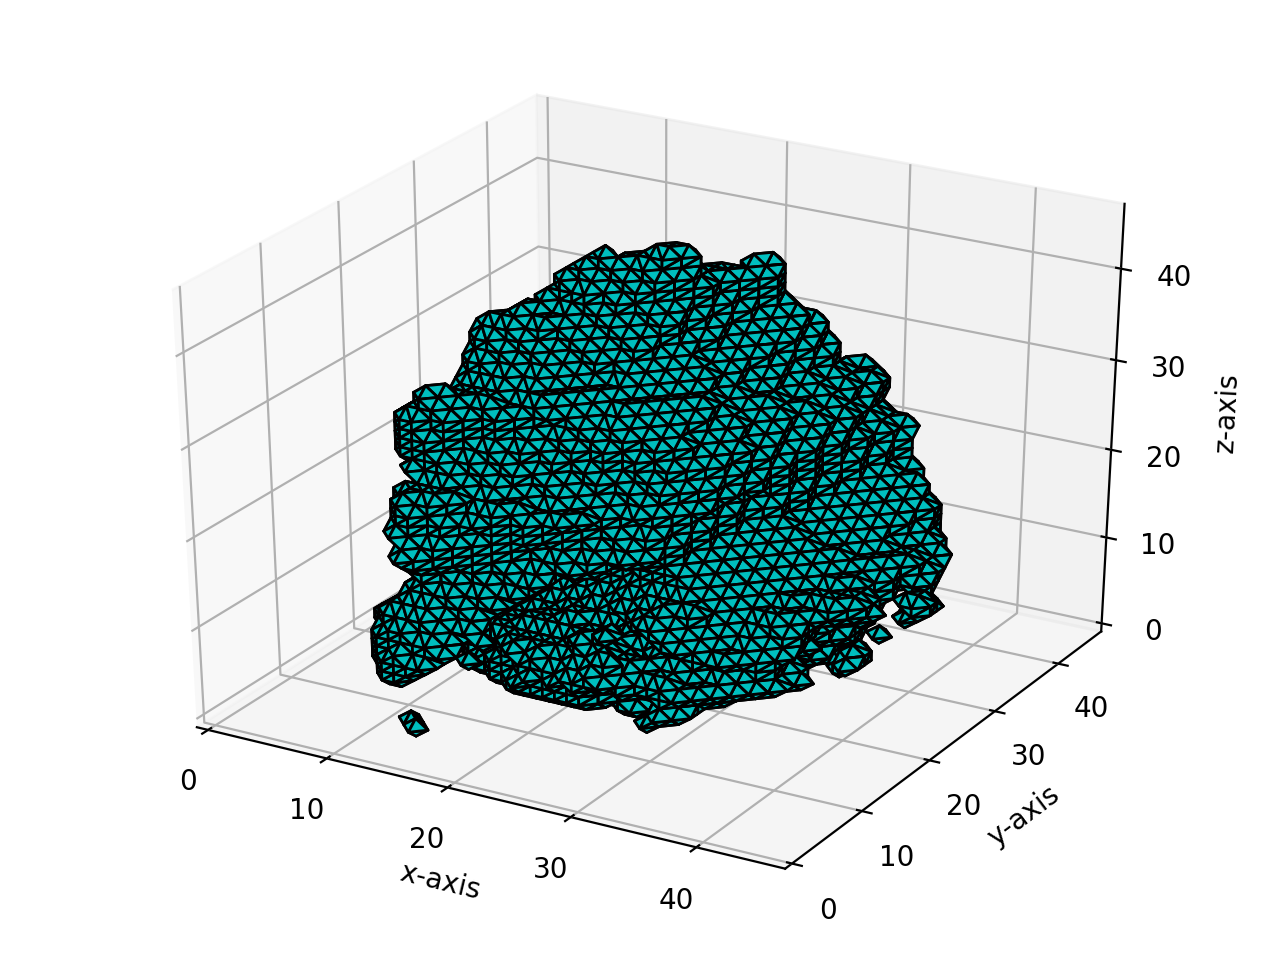

 done


In [19]:
dino_cut.run()

### Temple Results 

The the graph cuts was performed on high resolution temple visual hull. Note that the columns are quite thinner and represent the actual size of temple structure better compared to visual hull representation.

It can be seen from the logs that total of $11880$ voxels were removed from visual hull when graphs cut was performed. Visual hull initially had $62101$ voxels, and resulting structure had $50221$ voxels.

In [20]:
temple_cut = VolumetricGraphCuts(temple, temple_hull_hr)

Initializing Graph ...
	Graph -> created
	Nodes -> added
	T-links -> sink done -> source done
	N-links -> done
done


Running MaxFlow -> done
Create 3D Structure from graph ...
	Voxels in visual hull:  62101
	Number of voxels removed during graph-cuts:  11880
	Voxels in final result:  50221
done
Plot final result ->

<IPython.core.display.Javascript object>


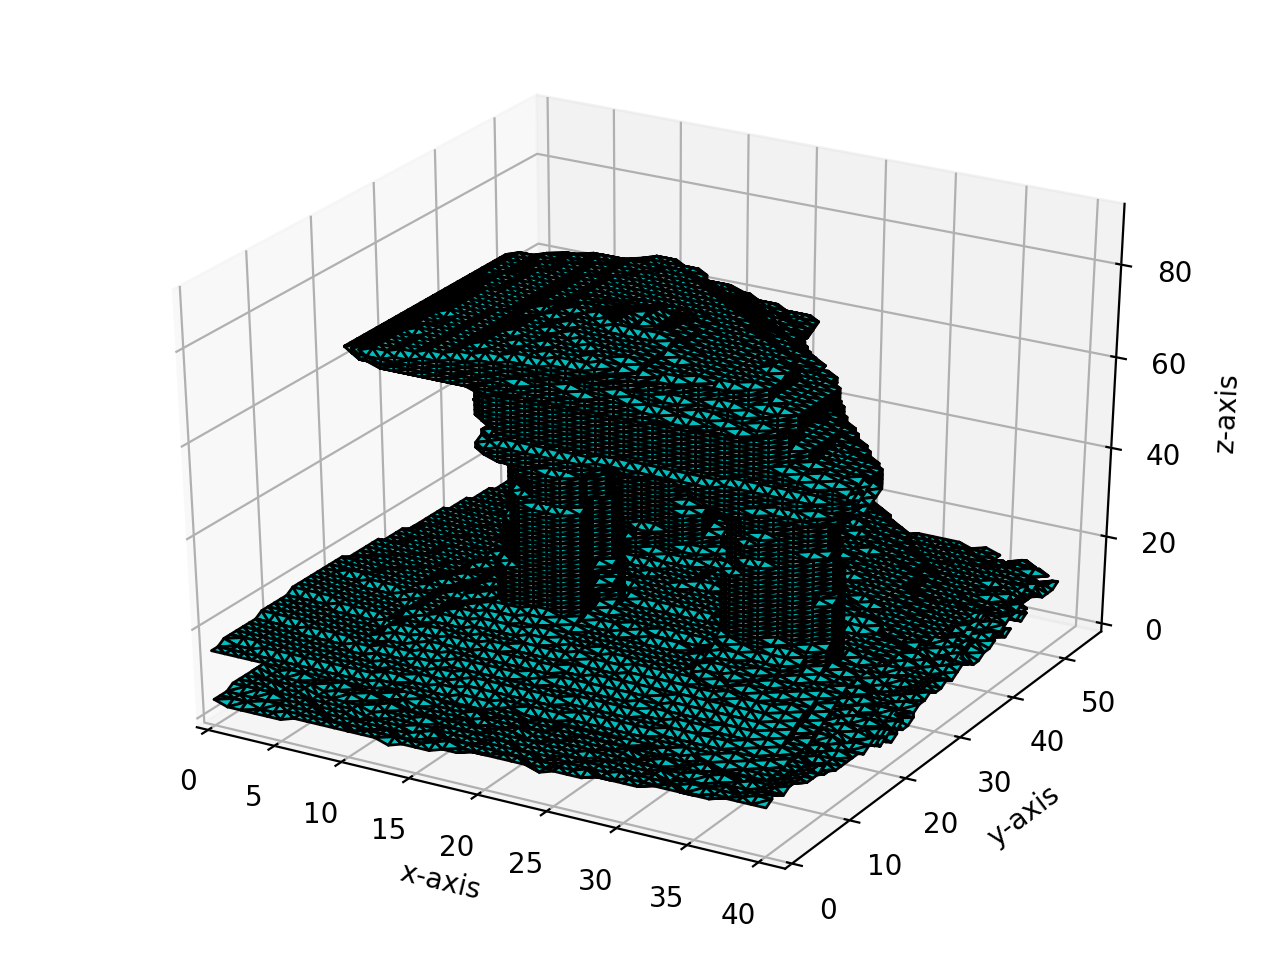

 done


In [21]:
temple_cut.run()

# Improvements
Many steps could be taken to improve this project

1. The graph cuts can be improved by using complex photo-consistency metrics that capture consistency better rather than just using variance of pixel intensities. 

2. The number of n-links can be increased by connecting more than 6 neighbors. A total of 32 n-links can be introduced for a single voxel. (6 faces + 8 vertices + 12 edges)

3. Robust photo-consistencies could improve graph-cuts performance too.

4. Better way to incorporate visible projections of a scene point will us a give representation of the structure in the graph.

5. Changing the value of hyper-parameter $\lambda$ to affect the graph-cuts performance 

6. Experimenting with different ways to connect t-links could also yeild better results

# Debug (plz ignore)

I just plotted weights of n-links for debugging purpose

<IPython.core.display.Javascript object>


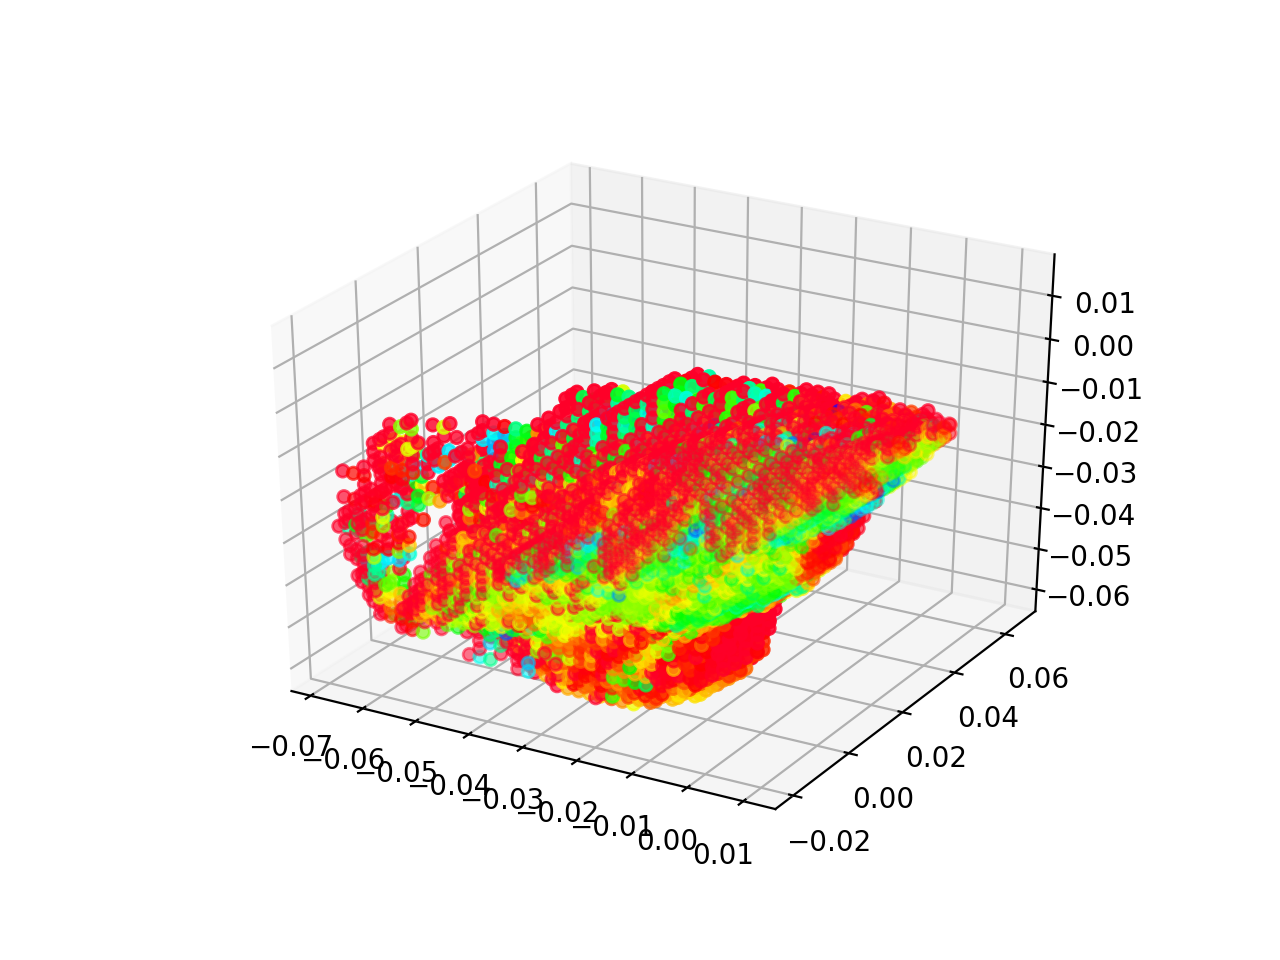

In [22]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

xs = dino_cut.weights[:,0]
ys = dino_cut.weights[:,1]
zs = dino_cut.weights[:,2]
wl = dino_cut.weights[:,3]
wu = dino_cut.weights[:,4]
wf = dino_cut.weights[:,5]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, c=wl, cmap='gist_rainbow')